In [22]:
import sys
sys.path.append('..')  

# Prend du temps
import Models.SqlCom as sq
# prends du temps
import deepLearning.lstm as ls

import Models.Shares as sm

import time
import Models.utils as ut

# Fichier lstm.py
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import Models.SqlCom as sq
import Models.utils as ut
import Models.Shares as sm
import datetime
import math
import matplotlib.pyplot as plt

from tensorflow import keras


In [23]:
## Model 1
model = keras.models.load_model('lstm_1.h5')

In [24]:
shM = sm.Shares(readOnlyThosetoUpdate=True)
curShare = shM.dfShares[shM.dfShares.symbol.str.endswith(".PA")].iloc[2] #shM.dfShares.iloc[0]
shareObj = curShare
# Si l'heure de curShare.lastRecord est inférieure à l'heure de curShare.closeRichMarketTime
if curShare.lastRecord.time() < curShare.closeRichMarketTime:
    # Change le jour pour jour n-1
    end_date = curShare.lastRecord - datetime.timedelta(days=1)
    # Maintient l'heure à curShare.closeRichMarketTime
    end_date = end_date.replace(hour=curShare.closeRichMarketTime.hour, minute=curShare.closeRichMarketTime.minute, second=curShare.closeRichMarketTime.second)
else:
    end_date = curShare.lastRecord

data_quots = shM.get_cotations_data_df(curShare, curShare.firstRecord, end_date)

df = ut.prepareData(curShare, data_quots) #column="openPrice"


I:\drive\Projects\dash_deep\Models\SqlCom.py:181: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataFrame = pd.read_sql(select_query, self.connection, columns=columns)


In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df) 

# Split the dataset into training and testing sets
nb_minute_until_open = shareObj.openRichMarketTime.hour * 60 + shareObj.openRichMarketTime.minute
nb_minute_until_close = shareObj.closeRichMarketTime.hour * 60 + shareObj.closeRichMarketTime.minute
nb_quots_by_day = (nb_minute_until_close - nb_minute_until_open) + 1 # +1 interval inclus
nb_days_quots_total = len(dataset) // nb_quots_by_day

b_days_quots_train = nb_days_quots_total - 1
# pour simplification apprentissage on ne prend que 1 dixieme des derniere cotations 
nb_days_quots_test = 1
nb_days_quots_train = nb_days_quots_total//10

nb_days_skipped = math.floor(nb_days_quots_total/10) -1
skipped_size = nb_days_skipped * nb_quots_by_day

train_size = nb_days_quots_train * nb_quots_by_day
print(skipped_size, train_size, nb_days_quots_train)
#train, test = dataset[skipped_size:skipped_size+train_size, :], dataset[skipped_size+train_size:len(dataset), :]
test = dataset[0:nb_days_quots_train * nb_quots_by_day, :]
#
#train_size = nb_days_quots_train * nb_quots_by_day
#train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

look_back = 60


In [5]:
def create_dataset(dataset, look_back, nb_quots_by_day):
    data_X, data_Y = [], []
    for i in range(0,len(dataset) - 2*look_back, 1):
         # on évite que le train soit en transition entre 2 journée
         # ou que le train soit sur une journée et que le test sur une autre (peux etre à changer)
        if (i//nb_quots_by_day ==  (i+2*look_back)//nb_quots_by_day ):
            a = dataset[i:(i + look_back), :]
            data_X.append(a)
            b = dataset[(i + 2*look_back), :]
            data_Y.append(b)
    return np.array(data_X), np.array(data_Y)

testX,testY= create_dataset(test, look_back, nb_quots_by_day)

In [6]:
print(testX.shape)


(26979, 60, 1)


In [9]:
result = np.array([])
for i in range(len(testX)-1, len(testX)-201, -1):
    result = np.append(result, model.predict(testX[i:i+1,:,:]))


1/1 [==============================] - 0s 16ms/step


In [10]:
result.shape

(200,)

In [11]:
testX.shape

(26979, 60, 1)

In [12]:
nb_quots_by_day

511

In [13]:
nb_days_quots_train * (nb_quots_by_day - 2*look_back)

26979

In [14]:
cptOk = 0
cptKO = 0
cptOkcroissant = 0
cptOkdecroissant = 0
cptKOcroissant = 0
cptKOdecroissant = 0
nbCroissant =  0
nbDecroissant =  0
for i in range(  200 - look_back):
    if (testX[i + look_back][59] >= testX[i][59][0]): # est croissant
        nbCroissant  += 1
        if (result[i][0] >= testX[i][59][0]): # a predit croissant
            cptOk +=1
            cptOkcroissant += 1
        else:
            cptKO += 1
            cptKOcroissant += 1
    else:# est decroissant
        nbDecroissant += 1
        if (result[i][0] < testX[i][59][0]): # a predit decroissant
            cptOk += 1
            cptOkdecroissant += 1
        else:
            cptKO += 1
            cptKOdecroissant += 1
            

IndexError: invalid index to scalar variable.

In [50]:
result

array([[0.09049825],
       [0.09072993],
       [0.09104964],
       ...,
       [0.34212187],
       [0.3417533 ],
       [0.34128523]], dtype=float32)

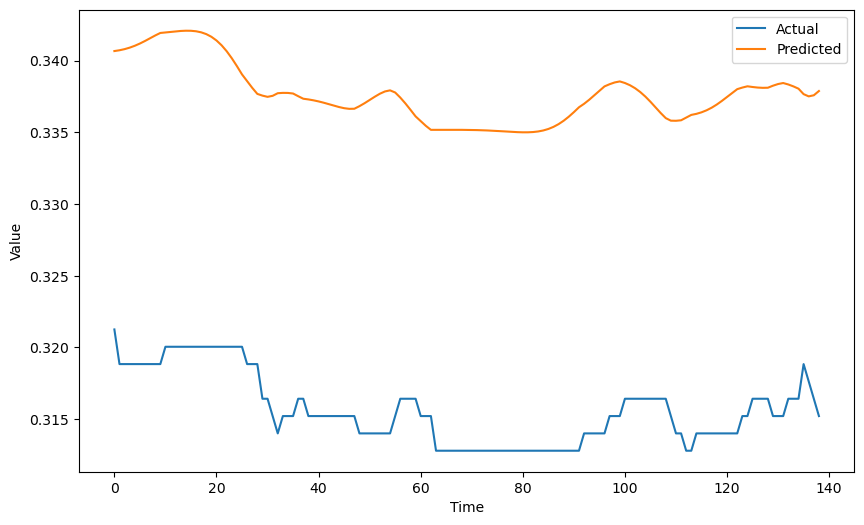

In [17]:
plt.figure(figsize=(10, 6)) 
plt.plot(testX[-61:-200:-1,59,0], label='Actual')
plt.plot(result[61:], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

In [53]:
testX.shape

(26979, 60, 1)

In [59]:
model.predict(testX[0:1])

1/1 [==============================] - 0s 18ms/step


array([[0.09049825]], dtype=float32)

In [58]:
testX[0:1].shape

(1, 60, 1)

In [62]:
testX[:,0,0].shape

(26979,)

In [63]:
result.shape

(26979, 1)